## Plot feature distribution over time

In [10]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,place_num,number,current_odds,current_place_odds,place,relevance,...,DamShowRate,DamSireShowRate,HorseJockeyShowRate,HorseTrainerShowRate,HorseBreederShowRate,RaceClassDifference,HasJockeyChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,2017-08-01 14:40:00,2301823,9,3,1,19.0,4.60,3,2,...,0.000000,0.206177,NaN,NaN,NaN,NaN,NaN,58.1,0.0,NaN
1,1,2017-08-01 14:40:00,2301823,9,3,2,1.3,1.06,1,4,...,0.688046,0.410526,NaN,1.000000,1.000000,3.0,1.0,57.2,0.0,NaN
2,2,2017-08-01 14:40:00,2301823,9,3,3,29.0,6.60,4,2,...,0.000000,0.456657,0.0,0.000000,0.000000,0.0,1.0,56.2,0.0,NaN
3,3,2017-08-01 14:40:00,2301823,9,3,4,29.0,6.60,9,1,...,0.000000,0.351125,0.0,0.000000,0.000000,2.0,0.0,56.2,1.4,NaN
4,4,2017-08-01 14:40:00,2301823,9,3,5,7.0,2.20,2,2,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,55.8,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458846,458846,2022-10-20 21:15:00,5452982,13,3,9,6.5,2.38,4,28,...,0.411221,0.274833,NaN,0.759849,0.759849,1.0,1.0,60.3,0.0,78.0
458847,458847,2022-10-20 21:15:00,5452982,13,3,10,9.0,3.00,1,29,...,0.301470,0.351122,1.0,1.000000,1.000000,0.0,0.0,60.3,1.4,74.0
458848,458848,2022-10-20 21:15:00,5452982,13,3,11,41.0,11.00,11,26,...,0.556330,0.117714,0.0,0.591281,0.242539,-1.0,1.0,59.9,0.0,78.0
458849,458849,2022-10-20 21:15:00,5452982,13,3,12,15.0,4.50,2,28,...,0.182581,0.388087,NaN,0.337973,0.206349,0.0,1.0,59.0,0.0,77.0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                 std
year-month          
2017-08     0.231493
2017-09     0.278354
2017-10     0.394513
2017-11     0.410529
2017-12     0.324052
...              ...
2022-06     0.283633
2022-07     0.227756
2022-08     0.226766
2022-09     0.292544
2022-10     0.373695

[61 rows x 1 columns]


<AxesSubplot:xlabel='HadLayoff', ylabel='year-month'>

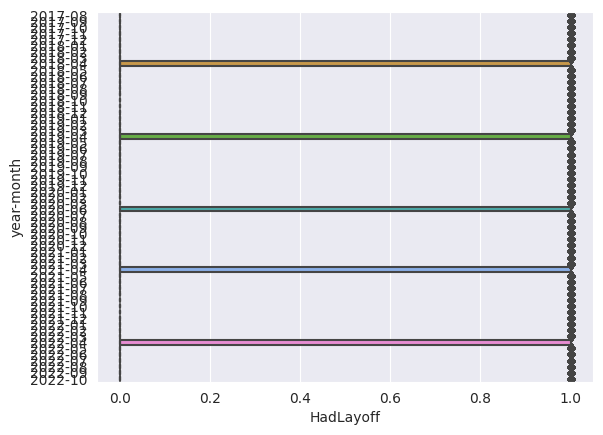

In [6]:
import seaborn as sns

COLUMN_NAME = "HadLayoff"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

In [55]:
from numpy.random import normal
from scipy.stats import stats
from numpy import std
from math import isnan
from statistics import mean

speed_figures = list(races_df["CurrentSpeedFigure"].values)
speed_figures = [speed_figure for speed_figure in speed_figures if not isnan(speed_figure)]
print(mean(speed_figures))
print(std(speed_figures))

speed_figures_sample = normal(loc=-12.8, scale=20.38, size=10000)
stats.percentileofscore(speed_figures_sample, -20)

-12.800445569308796
20.38557260828779


/tmp/ipykernel_327506/3946010061.py:13: DeprecationWarning: Please use `percentileofscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.percentileofscore(speed_figures_sample, -20)


36.68

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458


## Production sample inspection

In [1]:
import pandas as pd

production_race_df = pd.read_csv("../data/production_race_5458404.csv")

production_race_df

,Unnamed: 0,date_time,race_id,n_runners,place_num,number,current_odds,current_place_odds,place,relevance,...,HorseBreederShowRate,JockeyDistanceShowRate,JockeySurfaceShowRate,JockeyTrackShowRate,JockeyClassShowRate,TrainerTrackShowRate,TrainerClassShowRate,RaceClassDifference,HasJockeyChanged,WeightAllowanceExtractor
0,0,2022-10-22 14:20:00,5458404,15,5,1,8.0,2.5,-1,0,...,0.551541,0.875000,0.690819,0.730167,0.631979,0.379056,0.187530,1.0,True,0.0
1,1,2022-10-22 14:20:00,5458404,15,5,2,23.0,5.0,-1,0,...,0.749724,0.364782,0.363668,0.094030,0.272796,0.041795,0.131354,1.0,True,0.0
2,2,2022-10-22 14:20:00,5458404,15,5,3,29.0,6.0,-1,0,...,0.875000,0.000000,0.294166,0.595049,0.582013,0.218866,0.493007,1.0,True,0.0
3,3,2022-10-22 14:20:00,5458404,15,5,4,67.0,17.0,-1,0,...,0.315106,0.000000,0.124724,0.028833,0.225755,0.292241,0.366690,1.0,False,0.0
4,4,2022-10-22 14:20:00,5458404,15,5,5,51.0,11.0,-1,0,...,0.252274,1.000000,0.231295,0.320925,0.507346,0.477190,0.364906,1.0,False,0.0
5,5,2022-10-22 14:20:00,5458404,15,5,7,7.0,2.2,-1,0,...,0.208709,1.000000,0.126775,0.132607,0.293299,0.041795,0.131354,1.0,True,0.0
6,6,2022-10-22 14:20:00,5458404,15,5,8,15.0,3.4,-1,0,...,0.424336,1.000000,0.212456,0.725504,0.484007,0.057297,0.397502,0.0,False,0.0
7,7,2022-10-22 14:20:00,5458404,15,5,9,9.0,2.7,-1,0,...,0.797831,0.000000,0.278136,0.157756,0.259540,0.316880,0.387674,-1.0,False,0.0
8,8,2022-10-22 14:20:00,5458404,15,5,10,8.5,2.4,-1,0,...,0.440482,0.288909,0.304477,0.217090,0.389880,0.495187,0.417826,-1.0,True,0.0
9,9,2022-10-22 14:20:00,5458404,15,5,11,7.5,2.3,-1,0,...,0.059866,0.000000,0.117921,0.131282,0.194269,0.471175,0.408038,0.0,True,0.0
